# 2018111034

In [23]:
!pip install gif

## Excercise 1 - One vs One classifier

The aim of the excercise is to build a multiclass classifier using a binary classifier using a one-vs-one classifier. Similar to the tutorial, you are provided with a 3 class synthetic dataset. In a one-vs-one classifier, a binary classifier is learnt between every pair of class. You are required to write the code and visualize the decision boundaries for the one-vs-one classifier setting.

In [24]:
# Import util.ipynb for helper functions
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [25]:
# Imports

from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [26]:
fig = plt.figure(figsize=(8,8));

np.random.seed(4)

# Getting only linearly separable dataset
separable = False
while not separable:
    samples = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    green = samples[0][samples[1] == 2]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() 
                  or green[:, k].min() > blue[:, k].max() or green[:, k].min() > red[:, k].max() 
                  or blue[:, k].min() > green[:, k].max() or red[:, k].min() > green[:, k].max() for k in range(2)])

X, y = samples

y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 576x576 with 0 Axes>

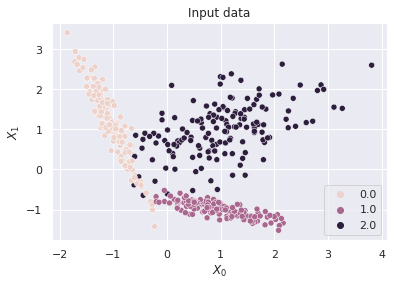

In [27]:
plot_2D_input_datapoints(X[:, :2], y)

In [28]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (315, 3)
Validation dataset:  (45, 3)
Test dataset:  (90, 3)


### Write your code below

In [31]:
epochs=1000
lr=0.01
n_examples, n_features = X_train.shape
_, n_outputs = Y_train.shape
classes = np.unique(Y_train)

W_k_classes = []
for k1 in classes:
    for k2 in classes:
        y = Y_train.ravel()
        idx = np.where((y == k1) | (y == k2))
        X = X_train[idx]
        Y = Y_train[idx]
        Y = np.where(Y == k1, 1, 0)
        n_samples, _ = X.shape
        const = 1 / np.sqrt(n_features)
        W = np.random.randn(n_features, n_outputs) * const
        W[-1, :] = 0
        for epoch in range(epochs):
            Y_pred = sigmoid(np.dot(X,W), 'no')
            gradient = np.dot(1 / n_samples * X.T ,(Y - Y_pred))
            W = W+ (lr * gradient)
            if(epoch % (epochs // 5) == 0):
                Y_pred = np.where(Y == 1, Y_pred, 1 - Y_pred)
                cost = -1 / Y.shape[0] * np.sum(np.log(Y_pred))
                print(f"Classes {k1}, {k2}: epoch {epoch}: train_loss {cost}")
        W_k_classes.append(W.ravel())

W=np.array(W_k_classes).T
W.shape

Classes 0, 0: epoch 0: train_loss 0.7299490512119811
Classes 0, 0: epoch 200: train_loss 0.17899304883892805
Classes 0, 0: epoch 400: train_loss 0.10721738272155142
Classes 0, 0: epoch 600: train_loss 0.07894439025433277
Classes 0, 0: epoch 800: train_loss 0.06336971989243678
Classes 0, 1: epoch 0: train_loss 0.3406496888258241
Classes 0, 1: epoch 200: train_loss 0.21628002019304196
Classes 0, 1: epoch 400: train_loss 0.17030698165766148
Classes 0, 1: epoch 600: train_loss 0.14598765622206736
Classes 0, 1: epoch 800: train_loss 0.1306611247742925
Classes 0, 2: epoch 0: train_loss 1.9931679490704821
Classes 0, 2: epoch 200: train_loss 0.794301065776606
Classes 0, 2: epoch 400: train_loss 0.43305199382435605
Classes 0, 2: epoch 600: train_loss 0.3230953415268112
Classes 0, 2: epoch 800: train_loss 0.2714376318738794
Classes 1, 0: epoch 0: train_loss 0.2781491477741491
Classes 1, 0: epoch 200: train_loss 0.1999103193301014
Classes 1, 0: epoch 400: train_loss 0.16488354759418833
Classes 1,

(3, 9)

In [32]:
def accuracy(X, Y, W):
    n_classes = int(np.sqrt(W.shape[1]))
    y_pred = np.argmax(np.dot(X, W), axis = 1) // n_classes
    return np.count_nonzero(Y.ravel() == y_pred) / Y.shape[0]

print(f"Training accuracy: {accuracy(X_train, Y_train, W)}")
print(f"Validation accuracy: {accuracy(X_val, Y_val, W)}")
print(f"Test accuracy: {accuracy(X_test, Y_test, W)}")

Training accuracy: 0.9111111111111111
Validation accuracy: 0.8888888888888888
Test accuracy: 0.9333333333333333
